In [1]:
# ========== INSTALLATION ==========

!pip install --upgrade kaggle torch torchvision scikit-learn matplotlib pandas pillow tqdm diffusers transformers accelerate torchmetrics
!pip install torchmetrics[image]
!pip install torch-fidelity

from google.colab import drive
drive.mount('/content/drive')

from google.colab import files
files.upload()

# API Kaggle configuration
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Downloading and unzipping data files
!mkdir -p ./data
!kaggle datasets download -d borhanitrash/cat-dataset -p ./data
!kaggle competitions download -c dogs-vs-cats -p ./data

!unzip -q ./data/cat-dataset.zip -d ./data/cats-only
!unzip -q ./data/dogs-vs-cats.zip -d ./data/mixed
!unzip -q ./data/mixed/train.zip -d ./data/mixed/train


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/borhanitrash/cat-dataset
License(s): MIT
 97% 261M/268M [00:00<00:00, 1.37GB/s]
100% 268M/268M [00:00<00:00, 1.36GB/s]
 95% 772M/812M [00:00<00:00, 1.27GB/s]
100% 812M/812M [00:00<00:00, 1.30GB/s]


In [8]:
# ========== REORGANIZING DATA FOR IMAGEFOLDER ==========
import os
import shutil
from glob import glob

print("Reorganizing folder 'mixed/train'...")
train_dir = './data/mixed/train'
cat_dir = os.path.join(train_dir, 'cat')
dog_dir = os.path.join(train_dir, 'dog')

# creating folder class if they don't exist
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

for f in glob(os.path.join(train_dir, 'cat.*.jpg')):
    shutil.move(f, cat_dir)
for f in glob(os.path.join(train_dir, 'dog.*.jpg')):
    shutil.move(f, dog_dir)

Reorganizing folder 'mixed/train'...


In [9]:
# ========== TRANSFORMS, DATA LOADING ==========
import random, numpy as np, torch
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(33)

data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def make_split(dataset, val_frac=0.10, seed=42):
    val_size = int(len(dataset) * val_frac)
    train_size = len(dataset) - val_size
    return random_split(
        dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(seed)
    )

def build_dataloaders(dataset_name, batch_size=64, val_frac=0.10, seed=33, transform=None):
    if dataset_name == "cats":
        root = "./data/cats-only"
    elif dataset_name == "mixed":
        root = "./data/mixed/train"
    ds = datasets.ImageFolder(root, transform=transform)
    train_ds, val_ds = make_split(ds, val_frac=val_frac, seed=seed)
    dl_train = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    dl_val = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    print(f"Dataset '{dataset_name.capitalize()}' loaded. Train: {len(train_ds)}, Val: {len(val_ds)}")
    return dl_train, dl_val, train_ds, val_ds

BATCH_SIZE = 32
dl_train, dl_val, train_ds, val_ds = build_dataloaders("cats", batch_size=BATCH_SIZE, transform=data_transforms)


Dataset 'Cats' loaded. Train: 26859, Val: 2984


In [10]:
# ========== DCGAN MODEL ==========

# inspiration: https://docs.pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

import torch.nn as nn

LATENT_DIM = 100
CHANNELS = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, g_features=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(LATENT_DIM, g_features * 8, 4, 1, 0, bias=False), nn.BatchNorm2d(g_features * 8), nn.ReLU(True),
            nn.ConvTranspose2d(g_features * 8, g_features * 4, 4, 2, 1, bias=False), nn.BatchNorm2d(g_features * 4), nn.ReLU(True),
            nn.ConvTranspose2d(g_features * 4, g_features * 2, 4, 2, 1, bias=False), nn.BatchNorm2d(g_features * 2), nn.ReLU(True),
            nn.ConvTranspose2d(g_features * 2, g_features, 4, 2, 1, bias=False), nn.BatchNorm2d(g_features), nn.ReLU(True),
            nn.ConvTranspose2d(g_features, CHANNELS, 4, 2, 1, bias=False), nn.Tanh())

    def forward(self, input): return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, d_features=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(CHANNELS, d_features, 4, 2, 1, bias=False), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(d_features, d_features * 2, 4, 2, 1, bias=False), nn.BatchNorm2d(d_features * 2), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(d_features * 2, d_features * 4, 4, 2, 1, bias=False), nn.BatchNorm2d(d_features * 4), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(d_features * 4, d_features * 8, 4, 2, 1, bias=False), nn.BatchNorm2d(d_features * 8), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(d_features * 8, 1, 4, 1, 0, bias=False), nn.Sigmoid())

    def forward(self, input): return self.main(input)


In [11]:
# ========== HYPERPARAMETER OPTIMALIZATION WITH OPTUNA ==========

!pip install -q optuna
import optuna
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
from torchmetrics.image.fid import FrechetInceptionDistance

# using subset of data (25% of original one)
train_ds, _ = make_split(datasets.ImageFolder(root="./data/cats-only", transform=data_transforms))
subset_indices = torch.randperm(len(train_ds))[:int(len(train_ds) * 0.25)]
train_ds_subset = Subset(train_ds, subset_indices)
dl_train_optuna = DataLoader(train_ds_subset, batch_size=BATCH_SIZE, shuffle=True)

# objective function for Optuna
# https://optuna.org/
# https://www.solvice.io/glossary/objective-function

def objective(trial):
    g_features = trial.suggest_categorical("g_features", [32, 64])
    d_features = trial.suggest_categorical("d_features", [32, 64])
    lr = trial.suggest_float("lr", 1e-5, 5e-4, log=True)
    beta1 = trial.suggest_float("beta1", 0.1, 0.9)
    generator_t = Generator(g_features=g_features).to(device)
    discriminator_t = Discriminator(d_features=d_features).to(device)
    optimizer_g = optim.Adam(generator_t.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizer_d = optim.Adam(discriminator_t.parameters(), lr=lr, betas=(beta1, 0.999))
    criterion = nn.BCELoss()

    for epoch in range(4): # short training foe each trial

        # GAN logic
        for real_images, _ in dl_train_optuna:
            real_images, b_size = real_images.to(device), real_images.size(0)
            discriminator_t.zero_grad()
            label = torch.full((b_size,), 1.0, device=device)
            output = discriminator_t(real_images).view(-1)
            criterion(output, label).backward()
            noise = torch.randn(b_size, LATENT_DIM, 1, 1, device=device)
            fake_images = generator_t(noise)
            label.fill_(0.0)
            output = discriminator_t(fake_images.detach()).view(-1)
            criterion(output, label).backward()
            optimizer_d.step()
            generator_t.zero_grad()
            label.fill_(1.0)
            output = discriminator_t(fake_images).view(-1)
            criterion(output, label).backward()
            optimizer_g.step()

    # FID logic
    fid = FrechetInceptionDistance(normalize=True).to(device)
    real_batch = next(iter(dl_val))[0].to(device)
    noise = torch.randn(real_batch.size(0), LATENT_DIM, 1, 1, device=device)
    fake_batch = generator_t(noise)
    fid.update(real_batch, real=True)
    fid.update(fake_batch, real=False)
    fid_score = fid.compute().item()
    return fid_score

# Optuna
study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 15) # 15 trials
best_params = study.best_trial.params
print("The best hyperparameters:", best_params)

[I 2025-06-08 18:17:45,381] A new study created in memory with name: no-name-7bd880c8-2288-4cc0-addb-b6b5cbff9c5d
[I 2025-06-08 18:18:36,451] Trial 0 finished with value: 459.75128173828125 and parameters: {'g_features': 64, 'd_features': 32, 'lr': 1.0656888356668974e-05, 'beta1': 0.3151161314667189}. Best is trial 0 with value: 459.75128173828125.
[I 2025-06-08 18:19:27,719] Trial 1 finished with value: 446.7983093261719 and parameters: {'g_features': 64, 'd_features': 32, 'lr': 3.549094260322603e-05, 'beta1': 0.8783584395750327}. Best is trial 1 with value: 446.7983093261719.
[I 2025-06-08 18:20:18,533] Trial 2 finished with value: 369.59234619140625 and parameters: {'g_features': 32, 'd_features': 64, 'lr': 5.7555705903600344e-05, 'beta1': 0.8107925741023129}. Best is trial 2 with value: 369.59234619140625.
[I 2025-06-08 18:21:09,068] Trial 3 finished with value: 324.0223083496094 and parameters: {'g_features': 64, 'd_features': 32, 'lr': 0.0004211409664872833, 'beta1': 0.8298935779

The best hyperparameters: {'g_features': 64, 'd_features': 64, 'lr': 0.00015774902724203805, 'beta1': 0.3966729176337193}


In [12]:
# ========== TRAINING WITH THE BEST HYPERPARAMETERS ==========
import pandas as pd
import datetime
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from PIL import Image
from torchmetrics.image.fid import FrechetInceptionDistance

# using the best hyperparameters found by Optuna
EPOCHS_FULL = 50
LR_BEST = best_params['lr']
BETA1_BEST = best_params['beta1']
G_FEATURES_BEST = best_params['g_features']
D_FEATURES_BEST = best_params['d_features']


# inicialization of final models (generator, discriminator) and optimizers
generator = Generator(g_features=G_FEATURES_BEST).to(device)
discriminator = Discriminator(d_features=D_FEATURES_BEST).to(device)
generator.apply(weights_init)
discriminator.apply(weights_init)

optimizer_g = optim.Adam(generator.parameters(), lr=LR_BEST, betas=(BETA1_BEST, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=LR_BEST, betas=(BETA1_BEST, 0.999))
criterion = nn.BCELoss()

# saving results and metrics
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = f"./dcgan_final_run_{ts}"
os.makedirs(f"{run_dir}/images", exist_ok=True)

fixed_noise = torch.randn(64, LATENT_DIM, 1, 1, device=device)
g_losses, d_losses, fid_history, fid_epochs = [], [], [], []

# FID
fid_metric = FrechetInceptionDistance(normalize=True).to(device)

for epoch in range(1, EPOCHS_FULL + 1):
    generator.train()

    for real_images, _ in tqdm(dl_train, desc=f"Epoch {epoch}/{EPOCHS_FULL}"):
        real_images, b_size = real_images.to(device), real_images.size(0)

        #  Discriminator training
        discriminator.zero_grad()
        label = torch.full((b_size,), 1.0, device=device)
        output = discriminator(real_images).view(-1)
        loss_d_real = criterion(output, label)
        loss_d_real.backward()

        noise = torch.randn(b_size, LATENT_DIM, 1, 1, device=device)
        fake_images = generator(noise)
        label.fill_(0.0)
        output = discriminator(fake_images.detach()).view(-1)
        loss_d_fake = criterion(output, label)
        loss_d_fake.backward()
        loss_d = loss_d_real + loss_d_fake
        optimizer_d.step()

        # Generator training
        generator.zero_grad()
        label.fill_(1.0)
        output = discriminator(fake_images).view(-1)
        loss_g = criterion(output, label)
        loss_g.backward()
        optimizer_g.step()

    g_losses.append(loss_g.item())
    d_losses.append(loss_d.item())

    # saving exemplary images from one of the epochs
    with torch.no_grad():
        fake = generator(fixed_noise).detach().cpu()
        save_image(fake, f"{run_dir}/images/epoch_{epoch:03d}.png", normalize=True)

    if epoch % 10 == 0:
        generator.eval()

        # validation
        for real_images, _ in dl_val:
            real_images = real_images.to(device)
            real_images_uint8 = (real_images * 0.5 + 0.5) * 255
            fid_metric.update(real_images_uint8.to(torch.uint8), real=True)

        # generation and processing of fake images
        with torch.no_grad():
            for _ in range(len(dl_val)): # generate the same number of fake and true images
                noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1, device=device)
                fake_images = generator(noise)
                fake_images_uint8 = (fake_images * 0.5 + 0.5) * 255
                fid_metric.update(fake_images_uint8.to(torch.uint8), real=False)

        fid_val = fid_metric.compute().item()
        fid_history.append(fid_val)
        fid_epochs.append(epoch)
        fid_metric.reset()

        print(f"Epoch {epoch}/{EPOCHS_FULL} – Loss D: {loss_d.item():.4f} – Loss G: {loss_g.item():.4f} – FID@{epoch}: {fid_val:.2f}")
    else:
        print(f"Epoch {epoch}/{EPOCHS_FULL} – Loss D: {loss_d.item():.4f} – Loss G: {loss_g.item():.4f}")


results_df = pd.DataFrame({
    'Epoch': range(1, EPOCHS_FULL + 1),
    'Generator_Loss': g_losses,
    'Discriminator_Loss': d_losses,})

fid_df = pd.DataFrame({'Epoch': fid_epochs, 'FID': fid_history})
results_df.to_csv(f"{run_dir}/training_losses.csv", index=False)
fid_df.to_csv(f"{run_dir}/fid_scores.csv", index=False)

Epoch 1/50: 100%|██████████| 840/840 [00:21<00:00, 38.99it/s]


Epoch 1/50 – Loss D: 0.8548 – Loss G: 3.4312


Epoch 2/50: 100%|██████████| 840/840 [00:20<00:00, 40.01it/s]


Epoch 2/50 – Loss D: 2.0793 – Loss G: 9.1128


Epoch 3/50: 100%|██████████| 840/840 [00:21<00:00, 39.75it/s]


Epoch 3/50 – Loss D: 0.3615 – Loss G: 3.6802


Epoch 4/50: 100%|██████████| 840/840 [00:21<00:00, 39.47it/s]


Epoch 4/50 – Loss D: 0.4473 – Loss G: 2.6215


Epoch 5/50: 100%|██████████| 840/840 [00:20<00:00, 40.75it/s]


Epoch 5/50 – Loss D: 0.2209 – Loss G: 3.9960


Epoch 6/50: 100%|██████████| 840/840 [00:21<00:00, 39.40it/s]


Epoch 6/50 – Loss D: 0.4279 – Loss G: 3.6815


Epoch 7/50: 100%|██████████| 840/840 [00:20<00:00, 40.26it/s]


Epoch 7/50 – Loss D: 1.0295 – Loss G: 6.3713


Epoch 8/50: 100%|██████████| 840/840 [00:20<00:00, 40.23it/s]


Epoch 8/50 – Loss D: 0.4189 – Loss G: 4.8178


Epoch 9/50: 100%|██████████| 840/840 [00:21<00:00, 39.45it/s]


Epoch 9/50 – Loss D: 0.7147 – Loss G: 9.1249


Epoch 10/50: 100%|██████████| 840/840 [00:20<00:00, 40.00it/s]


Epoch 10/50 – Loss D: 0.7050 – Loss G: 2.1254 – FID@10: 80.10


Epoch 11/50: 100%|██████████| 840/840 [00:20<00:00, 40.24it/s]


Epoch 11/50 – Loss D: 0.4542 – Loss G: 2.8303


Epoch 12/50: 100%|██████████| 840/840 [00:21<00:00, 39.53it/s]


Epoch 12/50 – Loss D: 0.8976 – Loss G: 9.3966


Epoch 13/50: 100%|██████████| 840/840 [00:21<00:00, 38.73it/s]


Epoch 13/50 – Loss D: 0.4080 – Loss G: 4.5368


Epoch 14/50: 100%|██████████| 840/840 [00:21<00:00, 38.70it/s]


Epoch 14/50 – Loss D: 0.4597 – Loss G: 1.6702


Epoch 15/50: 100%|██████████| 840/840 [00:21<00:00, 39.34it/s]


Epoch 15/50 – Loss D: 0.4237 – Loss G: 5.7344


Epoch 16/50: 100%|██████████| 840/840 [00:21<00:00, 39.83it/s]


Epoch 16/50 – Loss D: 0.5310 – Loss G: 2.7266


Epoch 17/50: 100%|██████████| 840/840 [00:21<00:00, 39.53it/s]


Epoch 17/50 – Loss D: 0.3999 – Loss G: 6.0533


Epoch 18/50: 100%|██████████| 840/840 [00:21<00:00, 39.65it/s]


Epoch 18/50 – Loss D: 0.4941 – Loss G: 2.1437


Epoch 19/50: 100%|██████████| 840/840 [00:21<00:00, 38.95it/s]


Epoch 19/50 – Loss D: 0.2754 – Loss G: 3.7974


Epoch 20/50: 100%|██████████| 840/840 [00:20<00:00, 40.09it/s]


Epoch 20/50 – Loss D: 0.2492 – Loss G: 3.9104 – FID@20: 62.35


Epoch 21/50: 100%|██████████| 840/840 [00:21<00:00, 39.73it/s]


Epoch 21/50 – Loss D: 0.2582 – Loss G: 4.5587


Epoch 22/50: 100%|██████████| 840/840 [00:21<00:00, 39.52it/s]


Epoch 22/50 – Loss D: 0.1485 – Loss G: 4.1049


Epoch 23/50: 100%|██████████| 840/840 [00:21<00:00, 39.61it/s]


Epoch 23/50 – Loss D: 0.4698 – Loss G: 6.2136


Epoch 24/50: 100%|██████████| 840/840 [00:21<00:00, 38.85it/s]


Epoch 24/50 – Loss D: 0.1529 – Loss G: 4.2691


Epoch 25/50: 100%|██████████| 840/840 [00:21<00:00, 39.55it/s]


Epoch 25/50 – Loss D: 0.1779 – Loss G: 5.4994


Epoch 26/50: 100%|██████████| 840/840 [00:21<00:00, 39.99it/s]


Epoch 26/50 – Loss D: 0.2009 – Loss G: 6.5992


Epoch 27/50: 100%|██████████| 840/840 [00:21<00:00, 39.79it/s]


Epoch 27/50 – Loss D: 0.2060 – Loss G: 8.0738


Epoch 28/50: 100%|██████████| 840/840 [00:21<00:00, 38.90it/s]


Epoch 28/50 – Loss D: 0.0644 – Loss G: 4.6704


Epoch 29/50: 100%|██████████| 840/840 [00:21<00:00, 39.97it/s]


Epoch 29/50 – Loss D: 0.1985 – Loss G: 6.7625


Epoch 30/50: 100%|██████████| 840/840 [00:20<00:00, 41.00it/s]


Epoch 30/50 – Loss D: 0.4976 – Loss G: 6.6854 – FID@30: 54.92


Epoch 31/50: 100%|██████████| 840/840 [00:21<00:00, 39.92it/s]


Epoch 31/50 – Loss D: 0.1803 – Loss G: 4.2107


Epoch 32/50: 100%|██████████| 840/840 [00:21<00:00, 39.50it/s]


Epoch 32/50 – Loss D: 0.0767 – Loss G: 5.1936


Epoch 33/50: 100%|██████████| 840/840 [00:21<00:00, 39.88it/s]


Epoch 33/50 – Loss D: 0.0866 – Loss G: 4.9886


Epoch 34/50: 100%|██████████| 840/840 [00:21<00:00, 39.37it/s]


Epoch 34/50 – Loss D: 0.5841 – Loss G: 2.6316


Epoch 35/50: 100%|██████████| 840/840 [00:21<00:00, 38.77it/s]


Epoch 35/50 – Loss D: 0.1517 – Loss G: 4.7811


Epoch 36/50: 100%|██████████| 840/840 [00:21<00:00, 39.97it/s]


Epoch 36/50 – Loss D: 0.0636 – Loss G: 6.2166


Epoch 37/50: 100%|██████████| 840/840 [00:21<00:00, 38.99it/s]


Epoch 37/50 – Loss D: 0.0586 – Loss G: 5.3915


Epoch 38/50: 100%|██████████| 840/840 [00:21<00:00, 39.26it/s]


Epoch 38/50 – Loss D: 0.3576 – Loss G: 4.9499


Epoch 39/50: 100%|██████████| 840/840 [00:21<00:00, 39.57it/s]


Epoch 39/50 – Loss D: 0.2198 – Loss G: 6.6649


Epoch 40/50: 100%|██████████| 840/840 [00:21<00:00, 39.20it/s]


Epoch 40/50 – Loss D: 0.1140 – Loss G: 4.2726 – FID@40: 53.35


Epoch 41/50: 100%|██████████| 840/840 [00:20<00:00, 40.21it/s]


Epoch 41/50 – Loss D: 0.0951 – Loss G: 5.6120


Epoch 42/50: 100%|██████████| 840/840 [00:21<00:00, 39.51it/s]


Epoch 42/50 – Loss D: 0.0423 – Loss G: 5.7738


Epoch 43/50: 100%|██████████| 840/840 [00:21<00:00, 39.73it/s]


Epoch 43/50 – Loss D: 0.1966 – Loss G: 3.9859


Epoch 44/50: 100%|██████████| 840/840 [00:21<00:00, 39.22it/s]


Epoch 44/50 – Loss D: 0.2524 – Loss G: 2.0809


Epoch 45/50: 100%|██████████| 840/840 [00:20<00:00, 40.56it/s]


Epoch 45/50 – Loss D: 0.0357 – Loss G: 4.8987


Epoch 46/50: 100%|██████████| 840/840 [00:21<00:00, 39.62it/s]


Epoch 46/50 – Loss D: 0.2518 – Loss G: 2.9117


Epoch 47/50: 100%|██████████| 840/840 [00:21<00:00, 39.64it/s]


Epoch 47/50 – Loss D: 0.0901 – Loss G: 5.8060


Epoch 48/50: 100%|██████████| 840/840 [00:21<00:00, 39.47it/s]


Epoch 48/50 – Loss D: 0.0151 – Loss G: 6.2104


Epoch 49/50: 100%|██████████| 840/840 [00:21<00:00, 39.18it/s]


Epoch 49/50 – Loss D: 0.0762 – Loss G: 5.3539


Epoch 50/50: 100%|██████████| 840/840 [00:21<00:00, 39.58it/s]


Epoch 50/50 – Loss D: 0.0664 – Loss G: 4.6425 – FID@50: 48.27


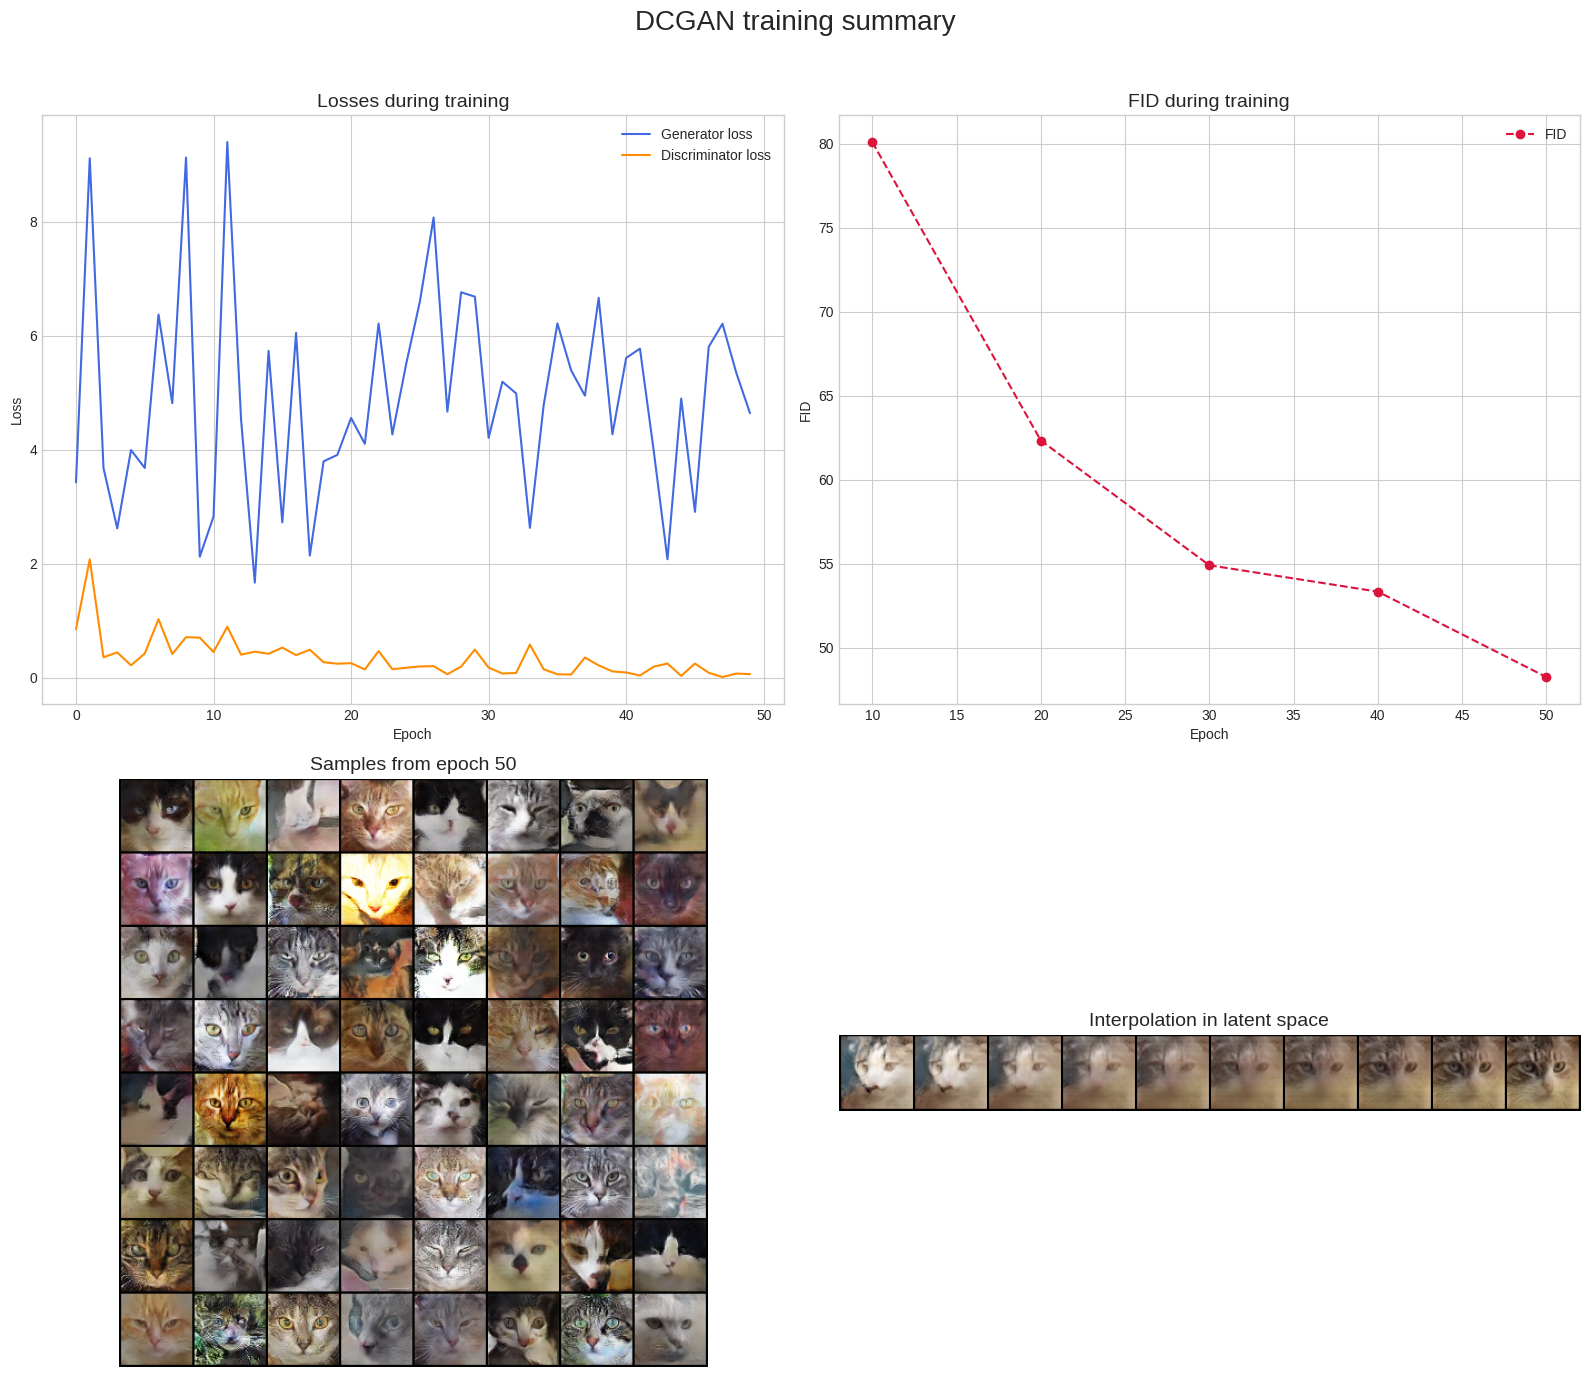

In [18]:

import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image
import os

plt.style.use('seaborn-v0_8-whitegrid')

# generating images for visualization -- first, we generate and save images so that we can load and display them later
generator.eval()
with torch.no_grad():
    # interpolation
    z0 = torch.randn(1, LATENT_DIM, 1, 1, device=device)
    z1 = torch.randn(1, LATENT_DIM, 1, 1, device=device)
    alphas = torch.linspace(0, 1, steps=10, device=device).view(-1, 1, 1, 1)
    z_interp = (1 - alphas) * z0 + alphas * z1
    x_interp = generator(z_interp).cpu()
    interpolation_path = f"{run_dir}/interpolation.png"
    save_image(x_interp, interpolation_path, nrow=10, normalize=True)

    # additional random probes
    random_noise = torch.randn(16, LATENT_DIM, 1, 1, device=device)
    random_samples = generator(random_noise).cpu()
    random_samples_path = f"{run_dir}/random_samples.png"
    save_image(random_samples, random_samples_path, nrow=4, normalize=True)

fig, axs = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle("DCGAN training summary", fontsize=20)

# Loss
axs[0, 0].plot(g_losses, label="Generator loss", color='royalblue')
axs[0, 0].plot(d_losses, label="Discriminator loss", color='darkorange')
axs[0, 0].set_title("Losses during training", fontsize=14)
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].legend()
axs[0, 0].grid(True)

# FID
axs[0, 1].plot(fid_epochs, fid_history, label="FID", color='crimson', marker='o', linestyle='--')
axs[0, 1].set_title("FID during training", fontsize=14)
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("FID")
axs[0, 1].legend()
axs[0, 1].grid(True)

# images from the last epoch
last_epoch_image_path = f"{run_dir}/images/epoch_{EPOCHS_FULL:03d}.png"
if os.path.exists(last_epoch_image_path):
    last_epoch_image = Image.open(last_epoch_image_path)
    axs[1, 0].imshow(last_epoch_image)
    axs[1, 0].set_title(f"Samples from epoch {EPOCHS_FULL}", fontsize=14)
axs[1, 0].axis('off')

# images from interpolation
if os.path.exists(interpolation_path):
    interp_image = Image.open(interpolation_path)
    axs[1, 1].imshow(interp_image)
    axs[1, 1].set_title("Interpolation in latent space", fontsize=14)
axs[1, 1].axis('off')

plt.tight_layout(rect = [0, 0, 1, 0.96])
plt.savefig(f"{run_dir}/combined_summary.png")
plt.show()